## Setup GCP

In [ ]:
PROJECT_ID = "silver-stratum-418405"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}
REGION = "us-central1"

In [ ]:
# Authenticate Google Cloud Account
! gcloud config set account "68133805090-compute@developer.gserviceaccount.com"

In [ ]:
# Get the source dataset from GCS
! gsutil cp gs://silver-stratum-bucket/SolarMonthlyData_2657Custs.csv .
! gsutil cp gs://silver-stratum-bucket/NonSolarMonthlyData_4064Custs.csv .

## Single series forecasting with Prophet
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.


In [2]:
!pip3 install prophet

  Using cached holidays-0.48-py3-none-any.whl.metadata (23 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 65.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 11.5 MB/s eta 0:00:00
Using cached holidays-0.48-py3-none-any.whl (1.0 MB)


In [9]:
from prophet import Prophet
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly
import plotly.offline as py
import warnings
warnings.filterwarnings('once')
%matplotlib inline 

#### Solar homes consumption


In [6]:
solar_data = pd.read_csv('./SolarMonthlyData_2657Custs.csv')
# Data preprocessing
# ======================================================================================
consumption_billrate = ['PK', 'LVP', 'SH', 'LVS','OP','OP1','OP2']
solar_data_consumption = solar_data[(solar_data['Netwk Bill Rate Type'].isin(consumption_billrate)) & (solar_data['Unit of me'] == 'KWH')].copy()
solar_data_consumption['Consumption Month'] = solar_data_consumption['Consumption Month'].apply(lambda x: "{:.4f}".format(x))
solar_data_consumption['Consumption Month'] = solar_data_consumption['Consumption Month'].astype('str')
solar_data_consumption['Consumption Month'] = pd.to_datetime(solar_data_consumption['Consumption Month'].apply(lambda x: dt.datetime.strptime(x, '%m.%Y')))
solar_data_consumption['house_type'] = 'solar'
solar_data_consumption.head()

,Customer ID,Netwk Bill Rate Type,Consumption Month,Sum,Unit of me,house_type
96,1,OP1,2007-01-01,168.073,KWH,solar
97,1,OP1,2008-01-01,145.746,KWH,solar
99,1,OP1,2009-01-01,189.888,KWH,solar
101,1,OP1,2010-01-01,163.563,KWH,solar
103,1,OP1,2011-01-01,176.308,KWH,solar


In [14]:
solar_data_grouped = solar_data_consumption.groupby(['Consumption Month']).agg(consumption = ('Sum','sum')).reset_index()
solar_data_grouped.head()

,Consumption Month,consumption
0,2007-01-01,419325.368
1,2007-02-01,386458.534
2,2007-03-01,464260.421
3,2007-04-01,492518.867
4,2007-05-01,588454.604


In [16]:
solar_data_grouped.columns = ['ds', 'y']
solar_data_grouped.head()

,ds,y
0,2007-01-01,419325.368
1,2007-02-01,386458.534
2,2007-03-01,464260.421
3,2007-04-01,492518.867
4,2007-05-01,588454.604


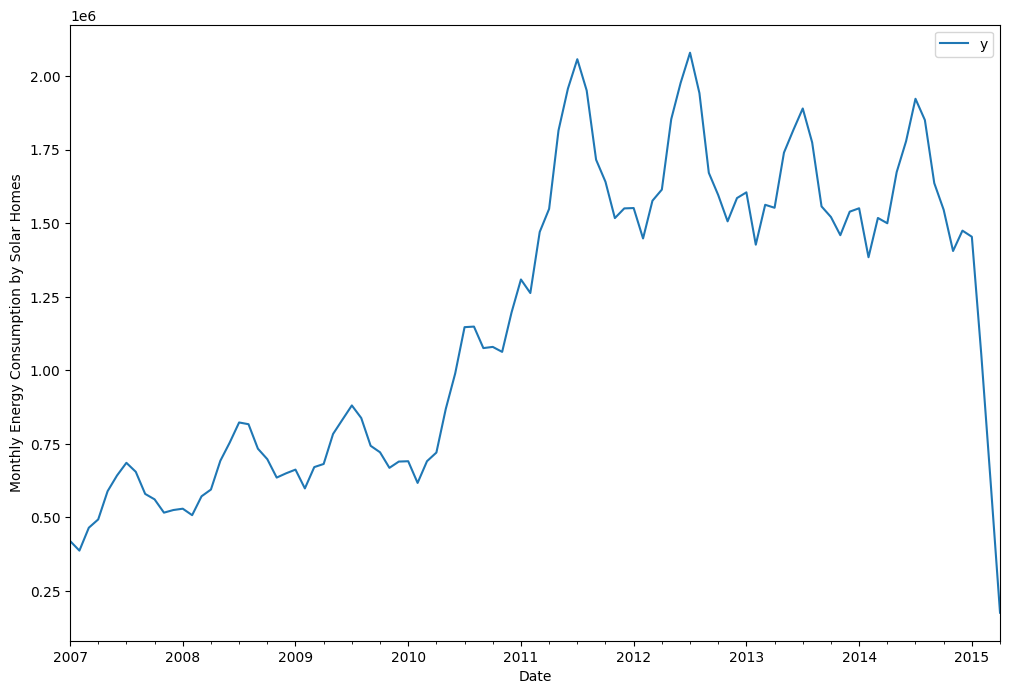

In [17]:
# Plot the data
ax = solar_data_grouped.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Energy Consumption by Solar Homes')
ax.set_xlabel('Date')

plt.show()

In [51]:
# Train and test data
end_train = 84

solar_data_train = solar_data_grouped.loc[:end_train, :].copy()
solar_data_test  = solar_data_grouped.loc[end_train:, :].copy()

In [52]:
solar_data_train.head()

,ds,y
0,2007-01-01,419325.368
1,2007-02-01,386458.534
2,2007-03-01,464260.421
3,2007-04-01,492518.867
4,2007-05-01,588454.604


In [53]:
solar_data_test.head()

,ds,y
84,2014-01-01,1550271.984
85,2014-02-01,1383801.212
86,2014-03-01,1517359.714
87,2014-04-01,1499319.689
88,2014-05-01,1673275.174


In [54]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)

In [55]:
my_model.fit(solar_data_train)

01:10:47 - cmdstanpy - INFO - Chain [1] start processing
01:10:47 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
test_dates = pd.DataFrame(solar_data_test['ds'])
forecast = my_model.predict(test_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-01,1.775548e+06,1.389522e+06,2.142541e+06
1,2014-02-01,1.727978e+06,1.359157e+06,2.095913e+06
2,2014-03-01,1.830770e+06,1.467983e+06,2.199001e+06
3,2014-04-01,1.870197e+06,1.512002e+06,2.255813e+06
4,2014-05-01,2.035852e+06,1.639017e+06,2.407751e+06


In [57]:
solar_data_test.head()

,ds,y
84,2014-01-01,1550271.984
85,2014-02-01,1383801.212
86,2014-03-01,1517359.714
87,2014-04-01,1499319.689
88,2014-05-01,1673275.174


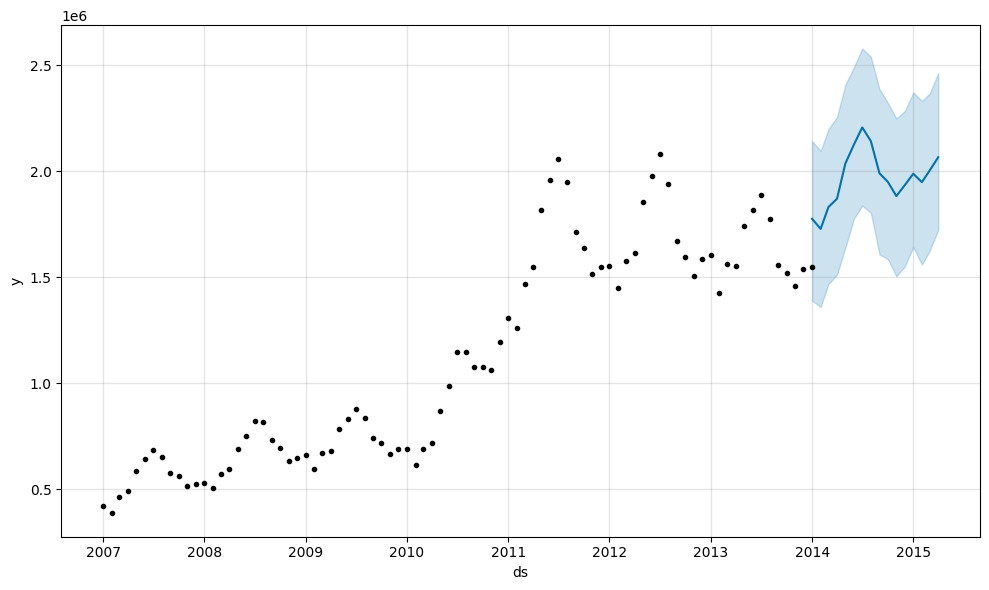

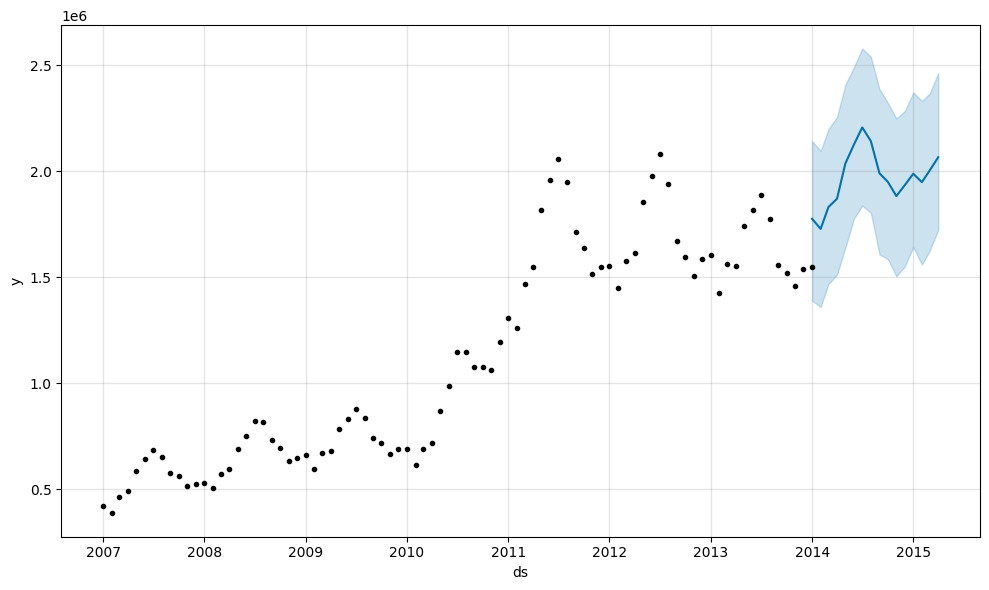

In [58]:
my_model.plot(forecast, uncertainty = True)

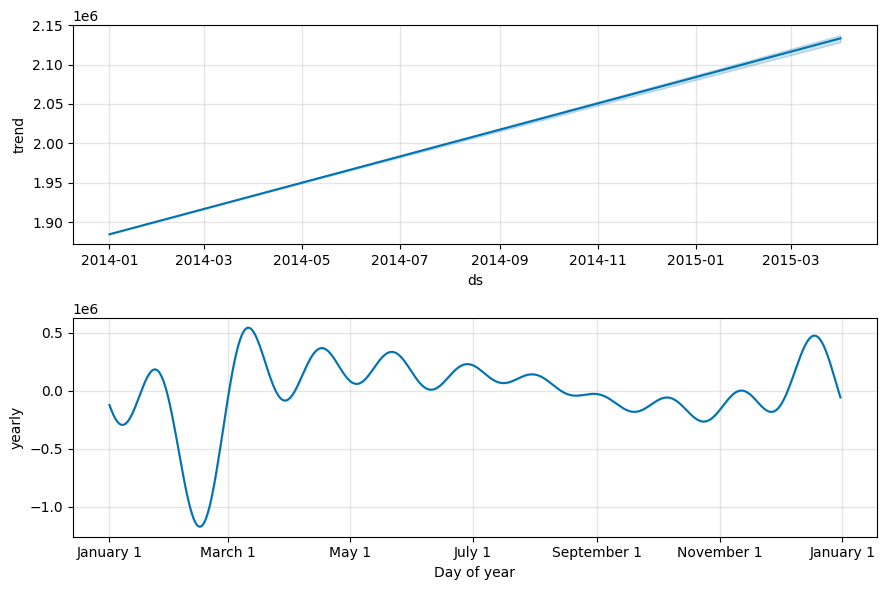

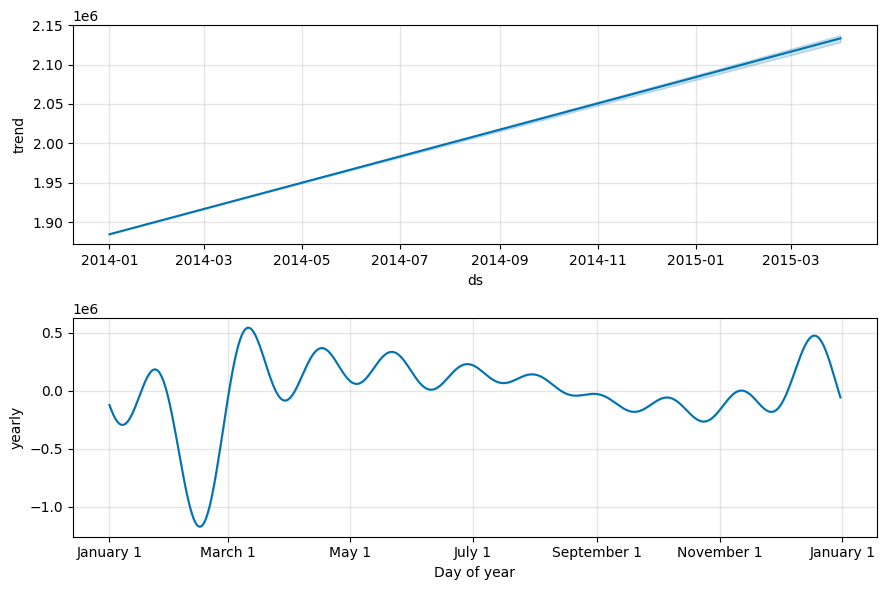

In [59]:
my_model.plot_components(forecast)

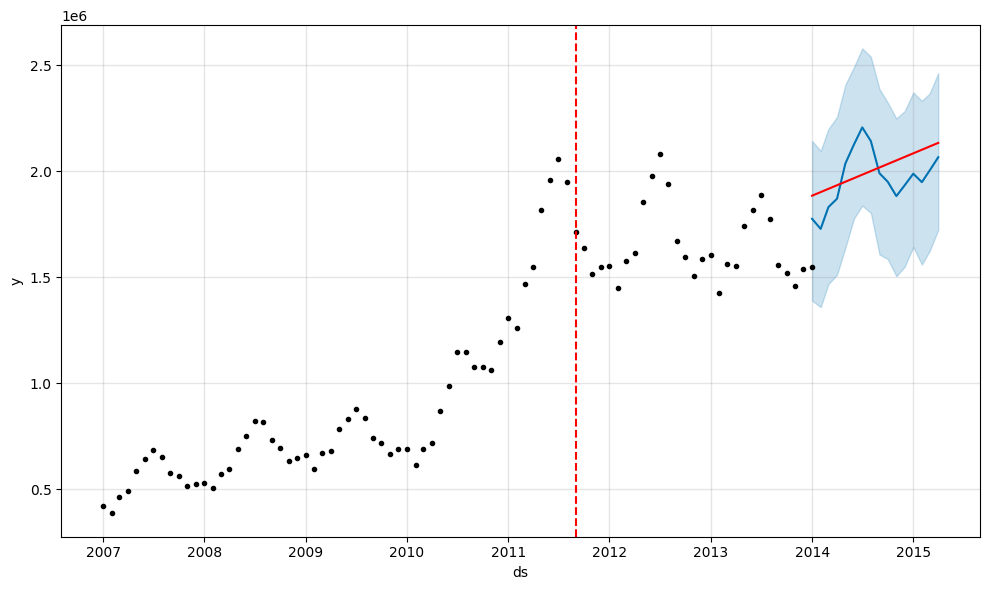

In [60]:
from prophet.plot import add_changepoints_to_plot
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

In [61]:
my_model.changepoints

3    2007-04-01
5    2007-06-01
8    2007-09-01
11   2007-12-01
13   2008-02-01
16   2008-05-01
19   2008-08-01
21   2008-10-01
24   2009-01-01
27   2009-04-01
29   2009-06-01
32   2009-09-01
35   2009-12-01
38   2010-03-01
40   2010-05-01
43   2010-08-01
46   2010-11-01
48   2011-01-01
51   2011-04-01
54   2011-07-01
56   2011-09-01
59   2011-12-01
62   2012-03-01
64   2012-05-01
67   2012-08-01
Name: ds, dtype: datetime64[ns]

#### Nonsolar homes consumption

In [40]:
nonsolar_data = pd.read_csv('./NonSolarMonthlyData_4064Custs.csv')
consumption_billrate = ['PK', 'LVP', 'SH', 'LVS','OP','OP1','OP2']
nonsolar_data_consumption = nonsolar_data[(nonsolar_data['Netwk Bill Rate Type'].isin(consumption_billrate)) & (nonsolar_data['Unit of me'] == 'KWH')].copy()
nonsolar_data_consumption['Consumption Month'] = nonsolar_data_consumption['Consumption Month'].apply(lambda x: "{:.4f}".format(x))
nonsolar_data_consumption['Consumption Month'] = nonsolar_data_consumption['Consumption Month'].astype('str')
nonsolar_data_consumption['Consumption Month'] = pd.to_datetime(nonsolar_data_consumption['Consumption Month'].apply(lambda x: dt.datetime.strptime(x, '%m.%Y')))
nonsolar_data_consumption['house_type'] = 'nonsolar'
nonsolar_data_consumption.head()

,Customer ID,Netwk Bill Rate Type,Consumption Month,Sum,Unit of me,house_type
1,3001,LVP,2007-01-01,213.489,KWH,nonsolar
2,3001,OP,2007-01-01,282.161,KWH,nonsolar
3,3001,LVS,2007-01-01,573.745,KWH,nonsolar
4,3001,OP1,2007-01-01,313.027,KWH,nonsolar
6,3001,OP,2008-01-01,367.863,KWH,nonsolar


In [41]:
nonsolar_data_grouped = nonsolar_data_consumption.groupby(['Consumption Month']).agg(consumption = ('Sum','sum')).reset_index()
nonsolar_data_grouped.head()

,Consumption Month,consumption
0,2007-01-01,605267.247
1,2007-02-01,559409.511
2,2007-03-01,662689.304
3,2007-04-01,706201.692
4,2007-05-01,835932.131


In [43]:
nonsolar_data_grouped.columns = ['ds', 'y']
nonsolar_data_grouped.head()

,ds,y
0,2007-01-01,605267.247
1,2007-02-01,559409.511
2,2007-03-01,662689.304
3,2007-04-01,706201.692
4,2007-05-01,835932.131


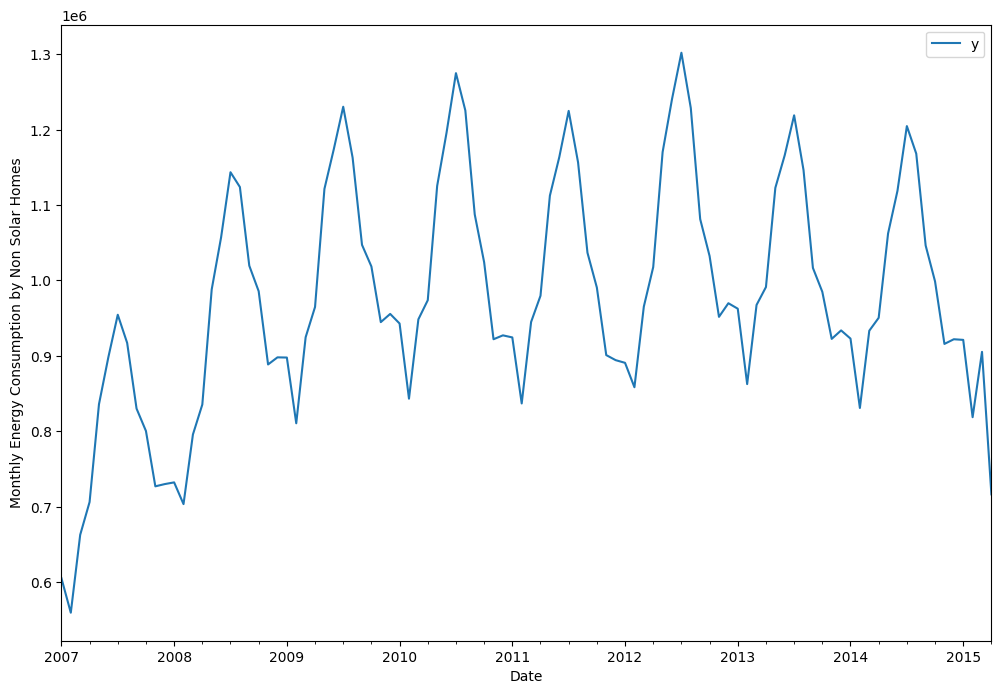

In [44]:
# Plot the data
ax = nonsolar_data_grouped.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Energy Consumption by Non Solar Homes')
ax.set_xlabel('Date')

plt.show()

In [63]:
# Train and test data
end_train = 72

nonsolar_data_train = nonsolar_data_grouped.loc[:end_train, :].copy()
nonsolar_data_test  = nonsolar_data_grouped.loc[end_train:, :].copy()

In [64]:
my_model2 = Prophet(interval_width=0.95)
my_model2.fit(nonsolar_data_train)

01:13:31 - cmdstanpy - INFO - Chain [1] start processing
01:13:31 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
test_dates2 = pd.DataFrame(nonsolar_data_test['ds'])
forecast2 = my_model2.predict(test_dates2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,9.785080e+05,9.497882e+05,1.006334e+06
1,2013-02-01,8.897669e+05,8.598828e+05,9.184110e+05
2,2013-03-01,1.006366e+06,9.794477e+05,1.034598e+06
3,2013-04-01,1.044302e+06,1.016492e+06,1.072970e+06
4,2013-05-01,1.190799e+06,1.161794e+06,1.220052e+06


In [66]:
nonsolar_data_test.head()

,ds,y
72,2013-01-01,962585.978
73,2013-02-01,862610.627
74,2013-03-01,967551.074
75,2013-04-01,991291.379
76,2013-05-01,1122878.555


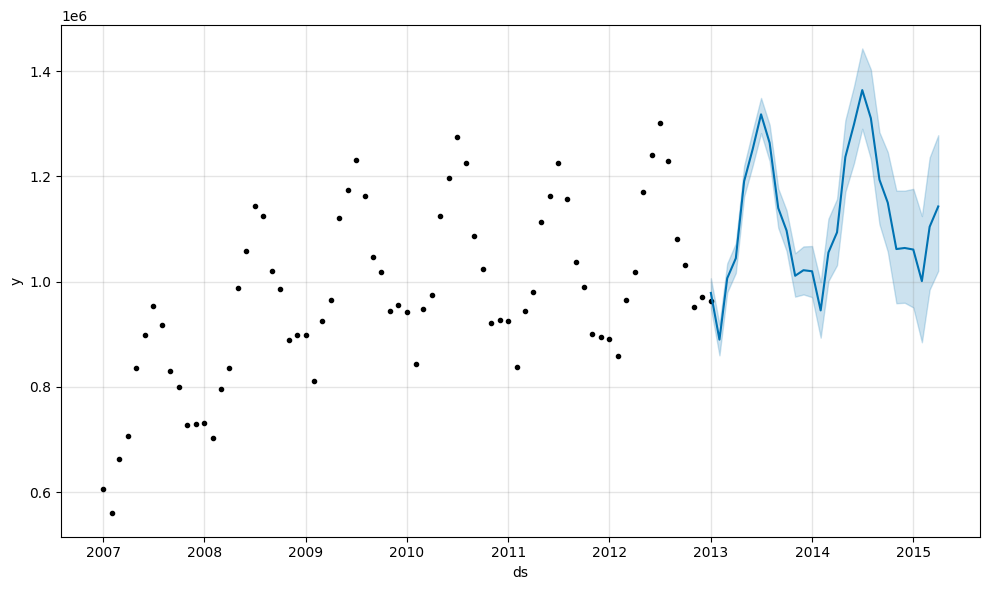

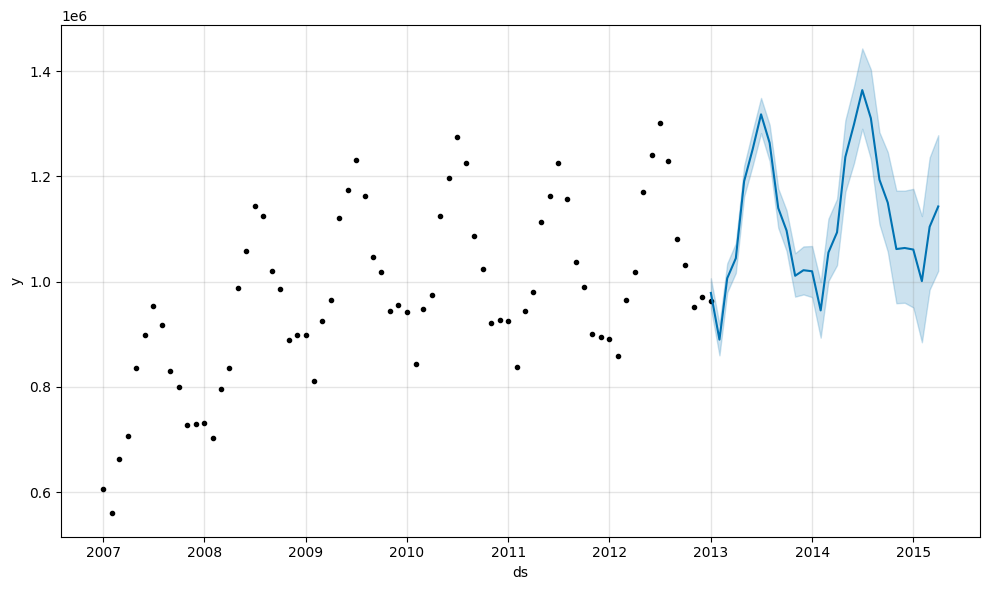

In [68]:
my_model2.plot(forecast2, uncertainty = True)

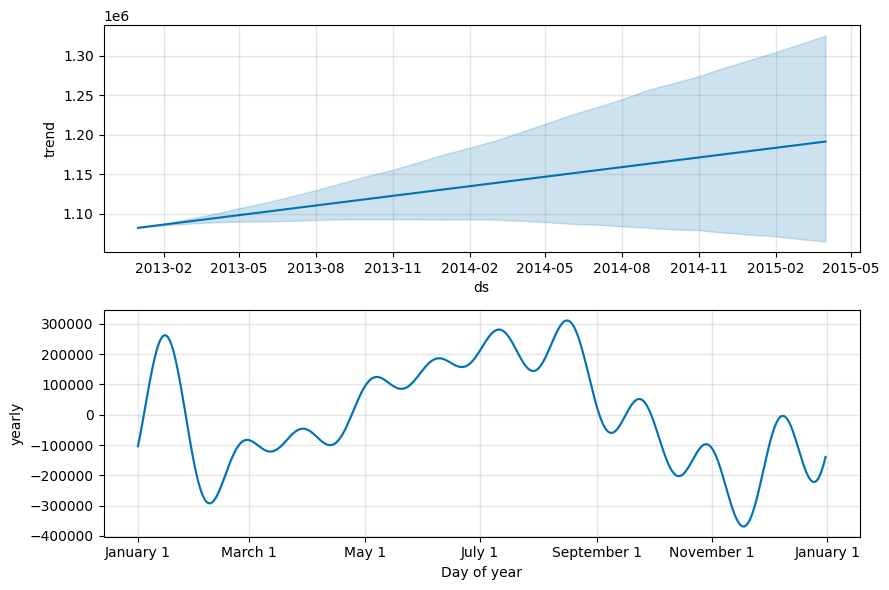

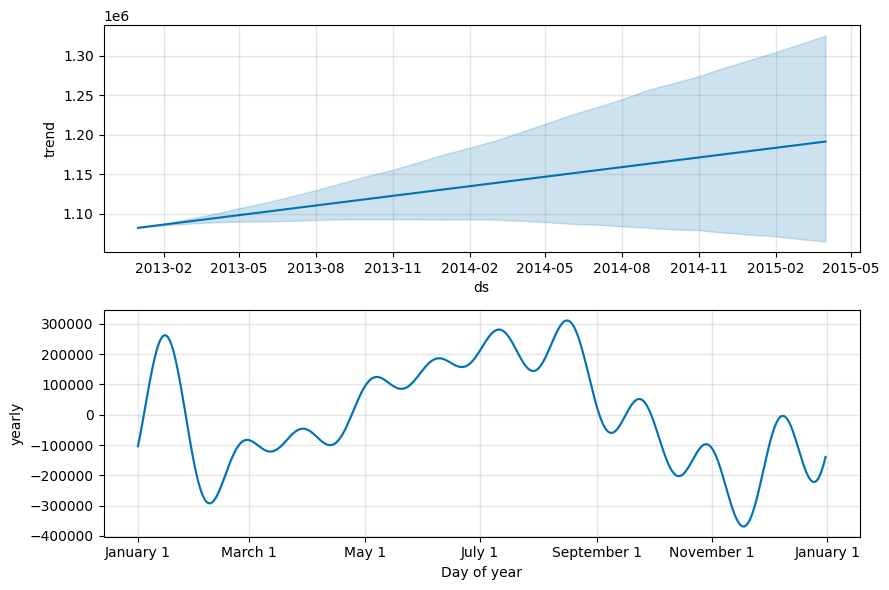

In [69]:
my_model2.plot_components(forecast2)

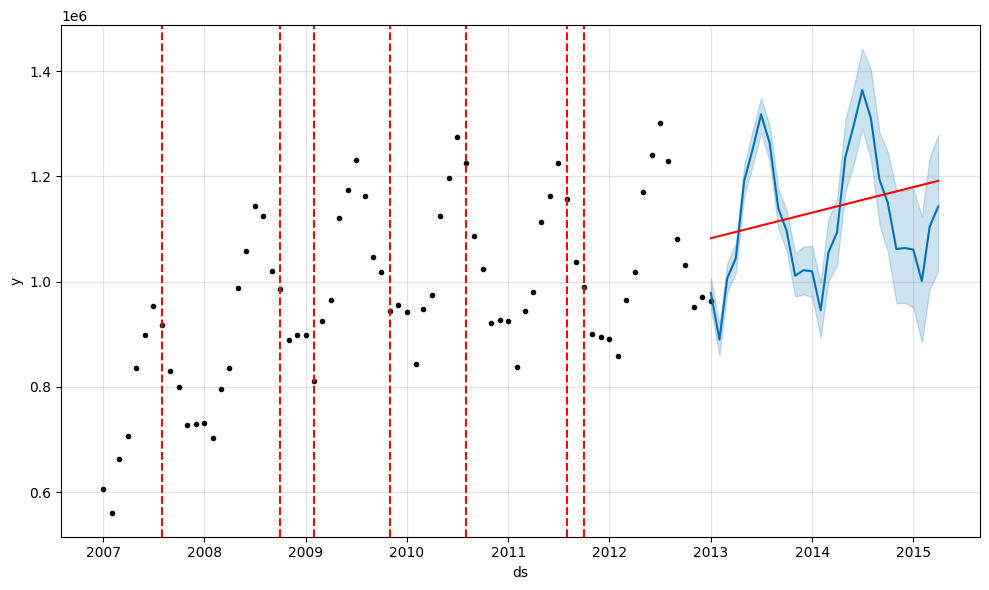

In [70]:
fig = my_model2.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), my_model2, forecast2)